# 1  Exploring the Data

In [14]:
# load dataset
from sklearn.datasets import load_digits

digits=load_digits()

print(digits.keys())

digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
print(target_names)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
[0 1 2 3 4 5 6 7 8 9]


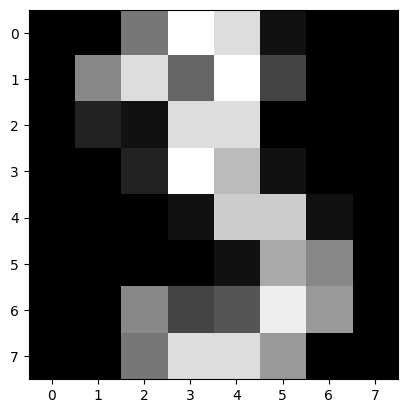

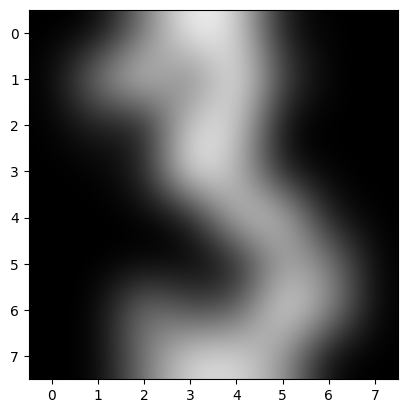

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#find an index with a value of three from target
img=images[np.array(np.where(target==3))[0][0],:,:]

assert 2==len(img.shape)

plt.figure()
plt.gray()
plt.imshow(img,interpolation="nearest")
plt.show()
plt.imshow(img, interpolation="bicubic")
plt.show()

In [16]:
from sklearn import model_selection

#filter 3 and 9
index =np.where((target==3) | (target==9))[0]
X_all=data[index]
y_all=target[index]

X_train,X_test,y_train,y_test=\
    model_selection.train_test_split(X_all, y_all, test_size=0.4, random_state=0)


# 2 Hand-crafted classifier

## 2.1 Feature Construction

In [17]:
import random

#find the pixel central of each image 
def feature2d(image): 
    random.seed(42)
    random_num=[random.random()*10-5 for i in range(64)]

    #choose feature1,feature2.
    #feature1=random num*image[i,j]
    #feature2=random num reverse*image[j,i]
    if len(image.shape)==2:
        return np.array([sum([random_num[x]*image[x//8,x%8] for x in range(64)]),\
                         sum([random_num[-x]*image[x%8,x//8] for x in range(64)])])
    else:
        return np.array([sum([random_num[x]*image[x] for x in range(64)]),\
                         sum([random_num[-x]*image[x%8*8+x//8] for x in range(64)])])

## 2.2 Scatterplot

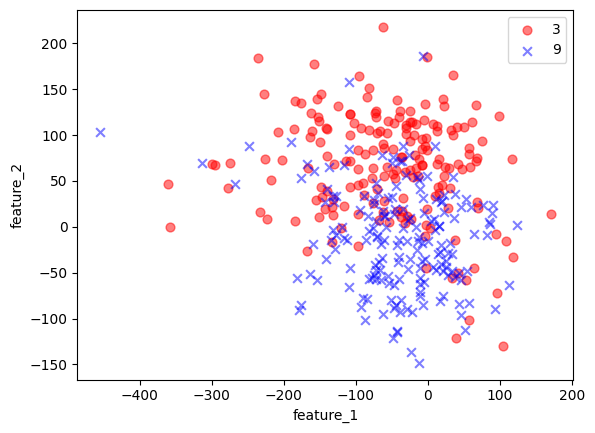

In [18]:
#feature construction
images_construction=np.array([feature2d(x) for x in images])
images3=images_construction[np.where(target==3)[0]]
images9=images_construction[np.where(target==9)[0]]
plt.figure()
plt.scatter(images3[:, 0], images3[:, 1], s=40, c='red', marker='o', alpha=0.5, label='3')
plt.scatter(images9[:, 0], images9[:, 1], s=40, c='blue', marker='x', alpha=0.5, label='9')
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.legend()
plt.show()

## 2.3 Decision Rule

In [19]:
def calculate_distance(point_a,point_b):
    return np.sqrt(np.sum((point_a-point_b)**2))

def nearest_mean(training_features,tarining_labels,test_features):
    training_features_3=training_features[np.where(tarining_labels==3)[0]]
    training_features_9=training_features[np.where(tarining_labels==9)[0]]

    #computer average features
    ave_3=np.mean(training_features_3,axis=0)
    ave_9=np.mean(training_features_9,axis=0)

    predicted_labels=np.array([3 if calculate_distance(ave_3,x)<=\
                               calculate_distance(ave_9,x) else 9 for x in test_features ])
    
    return predicted_labels

In [66]:
def error_rate(y_true, y_pred):
    assert len(y_true)==len(y_pred)

    return sum([1 if y_pred[i]!=y_true[i] else 0 for i in range(len(y_pred))])/len(y_true)

#feature construction
training_features=np.array([feature2d(x) for x in X_train])
test_features=np.array([feature2d(x) for x in X_test])

predicted_labels=nearest_mean(training_features,y_train,test_features)

#computer error ratio which is (FP+FN)/N
error_ratio = error_rate(y_test , predicted_labels)
print("error ratio is:{}".format(error_ratio))

error ratio is:0.22602739726027396


## 2.4 Visualize the decision regions

C:\Users\WY\AppData\Local\Temp\ipykernel_16928\143646344.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(X, Y, y_predict_matrix, linewidth=5, cmap=my_colormap)


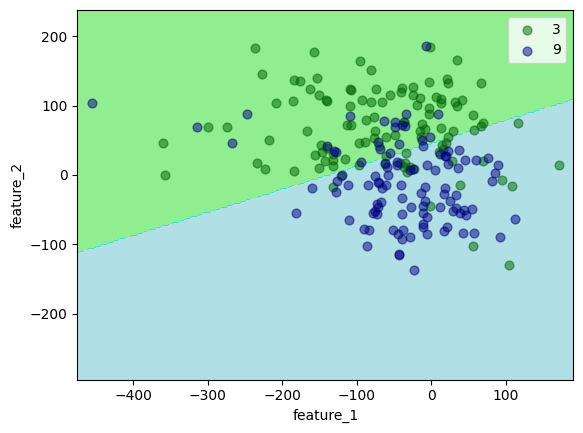

In [21]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(training_features,tarining_labels,axis):
    X,Y=np.meshgrid(
        np.linspace(axis[0], axis[1], 200),
        np.linspace(axis[2], axis[3], 200),
        )
    
    grid_matrix = np.c_[X.ravel(), Y.ravel()]

    y_predict = nearest_mean(training_features,tarining_labels,grid_matrix)
    y_predict_matrix = y_predict.reshape(X.shape)

    my_colormap = ListedColormap(['#90EE90', '#40E0D0', '#B0E0E6'])

    plt.contourf(X, Y, y_predict_matrix, linewidth=5, cmap=my_colormap)
    
    train_3=training_features[np.where(tarining_labels==3)[0]]
    train_9=training_features[np.where(tarining_labels==9)[0]]
    plt.scatter(train_3[:, 0], train_3[:, 1], s=40, c='#006400', marker='o', alpha=0.5, label='3')
    plt.scatter(train_9[:, 0], train_9[:, 1], s=40, c='#000080', marker='o', alpha=0.5, label='9')
    plt.xlabel("feature_1")
    plt.ylabel("feature_2")
    plt.legend()
    plt.show()
    
#find axis boundary
x_min=training_features[:,0].min() if training_features[:,0].min()<=\
        test_features[:,0].min() else test_features[:,0].min()
x_max=training_features[:,0].max() if training_features[:,0].max()>=\
        test_features[:,0].max() else test_features[:,0].max()
y_min=training_features[:,1].min() if training_features[:,1].min()<=\
        test_features[:,0].min() else test_features[:,0].min()
y_max=training_features[:,1].max() if training_features[:,1].max()>=\
        test_features[:,1].max() else test_features[:,1].max()

axis_boundry=[x_min-20,x_max+20,y_min,y_max+20]

plot_decision_boundary(training_features,y_train,axis_boundry)


# 3 LDA

## 3.1 Implement LDA training

In [22]:
import copy
def fit_lda(training_features,training_labels):
    assert training_features.shape[0]==len(training_labels)

    #each time find different class index to calculate mu and p
    labels=np.unique(training_labels)
    mu=np.empty(( len(labels),training_features.shape[1] ))
    p=np.empty((len(labels),1))
    covmat=np.zeros(( training_features.shape[1],training_features.shape[1] ))
    for i in range(len(labels)):
        mu[i]=np.mean(training_features[np.where(training_labels==labels[i])[0]],axis=0).reshape(1,-1)
        p[i]=len(training_features[np.where(training_labels==labels[i])[0]])/len(training_labels)

    #according to the previously calculated mu to calculate covarince
    for i in range(len(labels)):
        temp=training_features[np.where(training_labels==labels[i])[0]]-mu[i]
        covmat=covmat+temp.T.dot(temp)

    return mu,covmat,p
    
y_train_lda=copy.deepcopy(y_train)

y_train_lda[y_train_lda==3]=-1
y_train_lda[y_train_lda==9]=1
mu,covmat,p=fit_lda(X_train,y_train_lda)
print(mu.shape)
print(covmat.shape)
print(p.shape)

mu_task2,covmat_task2,p_task2=fit_lda(training_features,y_train_lda)
print(mu_task2.shape)
print(covmat_task2.shape)
print(p_task2.shape)

(2, 64)
(64, 64)
(2, 1)
(2, 2)
(2, 2)
(2, 1)


## 3.2 Implement LDA prediction

## 3.3 Visualization

## 3.4 Quantitative performance evaluation

# 4 SVM

## 4.1 Implement SVM training

In [72]:
from sklearn.model_selection import StratifiedKFold
def fit_svm(training_features,training_labels,epsilon=[0.1,1e-2,1e-3,1e-4],learning_rate="adaptive",eta0=1e-2,max_iter=5000,k_fold_num=5,n_iter_no_change=5):
    """
    input:
        training_features  -   N*D matrix
        training_labels    -   two class:-1,1
        epsilon            -   hyperparameter lamda,usually a list[0.01,1e-2,1e-3]
        learning_rate      -   two types:"adaptive":learning rate will decrease if loss not change after n iters,
                                         "constant":no change learning rate
        eta0               -   initial learning rate
        max_iter           -   max iteration num
        k_fold_num         -   cross validation to find the best hyperparameter in alpha list
        n_iter_no_change   -   number of iterations with no improvement to wait before stopping fitting
    """
    assert training_features.shape[0]==len(training_labels)
    assert n_iter_no_change<max_iter
    assert n_iter_no_change>=0 and max_iter>0 and eta0>0
    assert learning_rate=="adaptive" or learning_rate=="constant"

    def train(X_train,Y_train,X_test=None,Y_test=None,eps=0.1,learning_rate="adaptive",eta0=1e-2,max_iter=5000,n_iter_no_change=5):
        assert X_train.shape[0]==len(Y_train)

        if Y_test is not None:
            assert X_test.shape[0]==len(Y_test)

        w=np.random.normal(0,1,(X_train.shape[1],1))
        b=np.array([0])

        #decide learning_rate loop to decrease if check time.
        loss_curve=[]
        if learning_rate=="adaptive":
            loss_last_iter=0
            iter_no_change_time=0
            for i in range(max_iter):
                z=np.multiply(X_train.dot(w)+b,Y_train.reshape(-1,1))
                temp=1-z
                temp=(np.abs(temp)+temp)/2
                loss=np.sum(temp)*eps/X_train.shape[0]
                loss=loss+w.T.dot(w)/2

                if np.abs(loss-loss_last_iter)<1e-5:
                    iter_no_change_time=iter_no_change_time+1
                if iter_no_change_time>=n_iter_no_change:
                    eta0=eta0/10
                    iter_no_change_time=0
                
                loss_last_iter=loss
                loss_curve.append(loss)

                index=np.where(temp!=0)[0]

                w=w-(eta0*(np.sum(-Y_train[index].reshape(-1,1)*X_train[index],axis=0))/X_train.shape[0]).reshape(-1,1)
                b=b-eta0*np.sum(-Y_train[index])/X_train.shape[0]
        else:
            for i in range(max_iter):
                z=np.multiply(X_train.dot(w)+b,Y_train.reshape(-1,1))
                temp=1-z
                temp=(np.abs(temp)+temp)/2
                loss=np.sum(temp)*eps/X_train.shape[0]
                loss=loss+w.T.dot(w)/2
                loss_curve.append(loss)

                index=np.where(temp!=0)[0]

                w=w-(eta0*(np.sum(-Y_train[index].reshape(-1,1)*X_train[index],axis=0))/X_train.shape[0]).reshape(-1,1)
                b=b-eta0*np.sum(-Y_train[index])/X_train.shape[0]
        
        if Y_test  is not None:
            pred=X_test.dot(w)+b
            pred[pred>=0]=1
            pred[pred<0]=-1
            pred=sum([0 if pred[i]!=Y_test[i] else 1 for i in range(len(pred))])
            return pred/X_test.shape[0],w,b,loss_curve
        else:
            return w,b,loss_curve
    
    #first use cross validation to fine the best epsilon
    acc=[]
    for eps in epsilon:
        k_folds=StratifiedKFold(n_splits=k_fold_num)

        acc_ave=0
        for train_index,test_index in k_folds.split(training_features,training_labels):
            training_folds=training_features[train_index]
            training_labels_folds=training_labels[train_index]

            test_folds=training_features[test_index]
            test_labels_folds=training_labels[test_index]

            acc_part,_,_,_=train(training_folds,training_labels_folds,test_folds,test_labels_folds,eps,learning_rate,eta0,max_iter,n_iter_no_change)
            acc_ave=acc_ave+acc_part
        acc_ave=acc_ave/k_fold_num
        acc.append(acc_ave)
    
    #find the best epsilon
    eps_best=epsilon[acc.index(max(acc))]

    w,b,loss=train(training_features,training_labels,None,None,eps_best,learning_rate,eta0,max_iter,n_iter_no_change)
    
    return w,b,loss
    

y_train_svm=copy.deepcopy(y_train)

y_train_svm[y_train_svm==3]=-1
y_train_svm[y_train_svm==9]=1

w,b,loss=fit_svm(X_train,y_train_svm)
w_taks2,b_task2,loss_task2=fit_svm(training_features,y_train_svm)

array([2.80981567])

## 4.2 Impleement SVM prediction

In [73]:
def predicted_svm(w,b,test_features):
    pred=test_features.dot(w)+b
    pred[pred>=0]=1
    pred[pred<0]=-1
    return pred
   

predicted_labels_svm=predicted_svm(w,b,X_test)
predicted_labels_svm_task2=predicted_svm(w_taks2,b_task2,test_features)

In [75]:
#computer error ratio which is (FP+FN)/N
y_test_svm=copy.deepcopy(y_test)
y_test_svm[y_test_svm==3]=-1
y_test_svm[y_test_svm==9]=1

error_ratio = error_rate(y_test_svm , predicted_labels_svm)
error_ratio_task2 = error_rate(y_test_svm , predicted_labels_svm_task2)
print("64 features error ratio is:{}".format(error_ratio))
print("task2 2 features error ratio is:{}".format(error_ratio_task2))

64 features error ratio is:0.0136986301369863
task2 2 features error ratio is:0.0136986301369863


## 4.3 Visualization

## 4.4 Quantitative performance evaluation